# Segmentación mediante Watershed
#### Grupo 1: Mariana Nakagawa, María Pardo y Gema Perez.
---

Índice del Notebook:
1. Preparación de imágenes 
2. Conceptos teóricos del algoritmo Watershed
3. Flujo de la función .WatershedExerciseP2() creada
4. Ejemplo y discusión de resultados
5. Criterio en la selección de semillas
6. Conclusiones
7. Referencias
8. Autoría

## 1. Preparación de las imágenes

##### Importación de librerías

En esta sección vamos a proceder a visualizar las imágenes que hemos obtenido del repositorio de bases de datos Open Neuro, para poder evaluar los resultados de filtrado que debemos realizar. 

En primer lugar, cargaremos las imágenes con las que testearemos nuestro código. Se trata de imágenes de fMRI.

In [1]:
import os
import numpy as np
import nibabel as nib #nos permite leer las imagenes
%matplotlib inline 
import matplotlib 
import matplotlib.pyplot as plt 
import skimage
from skimage import io
from skimage import filters
from nilearn import datasets
from nilearn import plotting
import modules
from scipy import ndimage
import scipy.ndimage.filters as flt
from skimage.restoration import denoise_nl_means, estimate_sigma

In [3]:
img1 = nib.load(r'\Users\nakag\OneDrive\Escritorio\squizo\sub-02\anat\sub-02_T1w.nii.gz')

In [4]:
data = img1.get_fdata()  

In [5]:
print(data.shape)

(176, 256, 256)


In [6]:
print(data.dtype, img1.get_data_dtype())

float64 float32


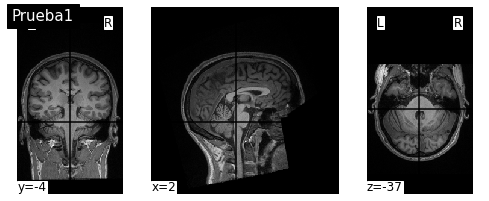

In [7]:
plotting.plot_img(img1, title="Prueba1",display_mode='ortho',cmap=plt.cm.gray )
plotting.show()  

Para poder añadirle el ruido a las imágenes, vamos a transformar los datos al formato array, y tras ello guardaremos un único corte (que hemos elegido de manera aleatoria) al que realizaremos la adición.

> En caso de querer disminuir el tiempo de ejecución descomente una de las líneas para disminuír el tamaño de las imágenes y por ende, el número de píxeles a analizar.<pre><code>a = np.array(skimage.transform.resize(img1.dataobj, (60,80)))
a = np.array(skimage.transform.rescale(img.dataobj,0.3))
</code></pre> Y comente la línea:<pre><code>a = np.array(img1.dataobj)
</code></pre>

In [8]:
#Vamos a probar los algoritmos con imágenes más pequeñas para disminuir el tiempo de computación
a = np.array(skimage.transform.resize(img1.dataobj, (120,160)))
#a = np.array(skimage.transform.rescale(img.dataobj,0.3))
#a = np.array(img1.dataobj)
a.shape

(120, 160, 256)

Una resonancia obtiene imagenes en 3D, por lo que a la hora de analizar el array obtenido, debemos tener en cuenta que las tres posiciones que obtenemos corresponden a:
1. La altura de la imagen.
2. El ancho de la imagen.
3. El número de corte.

Para poder analizar las imágenes, escogeremos un corte intermedio (128).

Normalizaremos las frecuencias de las imágenes, de forma que el rango de este nuevo histograma sea [0,1] Es decir, dividimos cada frecuencia entre el total de píxeles de la imagen.

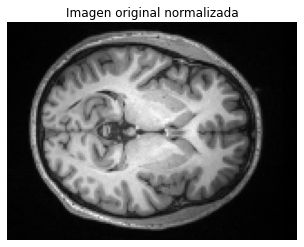

In [9]:
img_gray= a[:,:,128]
#normalizo la imagen
img_o=img_gray
img_o=img_o/np.max(img_o)
plt.title('Imagen original normalizada'), plt.axis('off')
plt.imshow(img_o, cmap=plt.cm.gray)


## 2. Conceptos teóricos del algoritmo Watershed

El **algoritmo watershed** es una técnica de segmentación que permite encontrar regiones de una imagen.

Se considera una imagen numérica como un ***relieve topográfico***, donde la intensidad del pixel se corresponde a la altura sobre el relieve. Si lo comparamos con la inundación del relieve topográfico, asumimos que el agua nace de los mínimos regionales (zona plana tal que el nivel de gris de todos los pixeles vecinos es estrictamente superior).

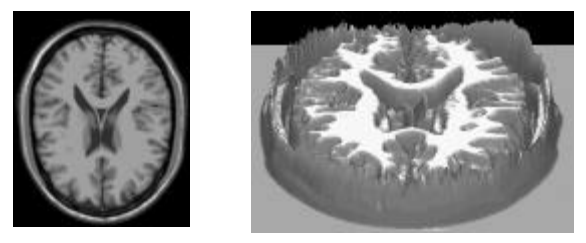

Con el objeto de separar zonas homogéneas de la imagen, **no se suele trabajar con la transformación watershed de la imagen original**, sino que se opera a partir de una **imagen gradiente**. En nuestro ejemplo trabajaremos con una imagen que filtraremos previamente con el filtro de Sobel. Así, se conseguiría que los **bordes de alto valor de gradiente** se correspondan con las fronteras obtenidas mediante la transformación Watershed.

## 3. Flujo de la función .WatershedExerciseP2() creada

Hemos creado una función para el algoritmo watershed, **.WatershedExerciseP2(img)** incluida en el archivo **modules.py**, que será la encargada de implementar una aproximación del algoritmo:

1. Aplicación de un filtro derivativo a la imagen para realizar un reconocimiento de bordes:
        Hemos decidido aplicar el filtro derivativo Sobel. Los filtros derivativos son capaces de destacar las zonas con un alto contraste local.Estos filtros funcionan mediante el cálculo del gradiente que en una imagen sería la diferencia de niveles de gris entre dos puntos de esta. Las zonas con un alto contraste local en una imagen serían los bordes  entre dos estructuras anatómicas.

2. Con la funcion de skimage, implementamos el algoritmo watershed cuyo parámetro será la imagen de gradiente calculada en el punto anterior. Esto se hace únicamente con el propósito de ver cómo cambia la máscara con una imposición de mínimos, ya que como veremos posteriormente, esta máscara no tiene ninguna utilidad.

3. Con la función **imimposemin** conseguimos modificar la imagen de tal forma que ésta tenga mínimos regionales en los puntos considerados. Para trabajar con esta función se deben introducir a la entrada dos imágenes:

        - La imagen de gradiente (calculada en el punto 1).
        - La imagen de máscara binaria del mismo tamaño que la imagen de gradiente, con los puntos en los que queremos     imponer  los mínimos marcados.

4. Nuevamente, con la fución de skimage, implementamos el **algoritmo Watershed** cuyo parámetro será la matriz calculada con la función **imimposemin**.

>Nótese que **cada nivel de color de las máscaras representa cada una una de las regiones** que ha segmentado el algoritmo, y por ende, cada región debería tener el mismo valor numérico en la matriz.

### ¿Qué conseguimos con .imimposemin()?

Dicha función modifica la imagen de la máscara en escala de grises utilizando la **reconstrucción morfológica** por lo que sólo tiene mínimo regional donde la imagen de marcador binario es distinto de cero. Para ello crearemos una máscara binaria en la que los puntos en los que tengamos un valor de 1 (ya que la imagen está normalizada) serán los que definan la ubicación en la imagen de máscara donde se impondrá un mínimo regional. Esta operación elimina todos los mínimos locales de la imagen original excepto los mínimos impuestos.
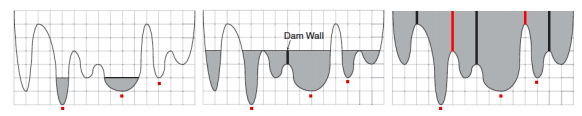


### Diagrama de flujo

<img src="watershed.png" alt="watershed" width="750"/>

## 4. Ejemplo y discusión de resultados

En este apartado vamos a comprobar el funcionamiento de la función **.WatershedExerciseP2()** del archivo **modules.py**. Véase que los parámetros de entrada a la función son la imagen a segmentar y el número de semillas que queremos introducir como mínimos.

In [29]:
%matplotlib auto
watershed1, watershed2 =modules.WatershedExerciseP2(img_o,5)
watershed5, watershed6 =modules.WatershedExerciseP2(img_o,20)
img_sobel=filters.sobel(img_o) 


Using matplotlib backend: Qt5Agg
Las coordenadas de las semillas son:  [[ 15  44]
 [ 38  20]
 [ 85  25]
 [106  66]
 [ 86 126]]
Las coordenadas de las semillas son:  [[ 34  41]
 [ 44  29]
 [ 30  63]
 [ 71  28]
 [ 82  42]
 [ 86  57]
 [ 83  67]
 [ 85 108]
 [ 75 113]
 [ 43 113]
 [ 46 105]
 [ 59 101]
 [ 77  99]
 [ 78  87]
 [ 79  79]
 [ 42  95]
 [ 41  82]
 [ 34  67]
 [ 29  51]
 [ 75  35]]


(Text(0.5, 1.0, 'Watershed sobre máscara binaria sustancia negra'),
 (-0.5, 159.5, 119.5, -0.5))

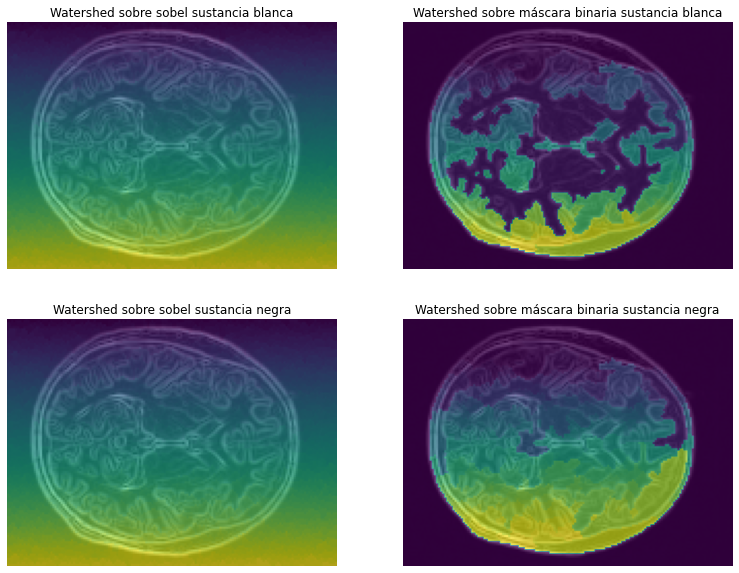

In [30]:
%matplotlib inline

fig = plt.figure(figsize=(13,10))
plt.subplot(221)
plt.imshow(img_sobel, cmap=plt.cm.gray)
plt.imshow(watershed1, cmap='viridis', alpha=0.7)
plt.title('Watershed sobre sobel sustancia blanca'), plt.axis('off')
plt.subplot(222)
plt.imshow(img_sobel, cmap=plt.cm.gray)
plt.imshow(watershed2, cmap='viridis', alpha=0.7)
plt.title('Watershed sobre máscara binaria sustancia blanca'), plt.axis('off')
plt.subplot(223)
plt.imshow(img_sobel, cmap=plt.cm.gray)
plt.imshow(watershed5, cmap='viridis', alpha=0.7)
plt.title('Watershed sobre sobel sustancia negra'), plt.axis('off')
plt.subplot(224)
plt.imshow(img_sobel, cmap=plt.cm.gray)
plt.imshow(watershed6, cmap='viridis', alpha=0.7)
plt.title('Watershed sobre máscara binaria sustancia negra'), plt.axis('off')


Como vemos la segmentación de la sustancia blanca es mucho más satisfactoria que la de la sustancia negra, debido a que al ser una región con menor área y mayor complejidad es mucho más complicado posicionar las semillas adecuadamente.

### Características de las máscaras 


Para poder comprender los resultados vamos a analizar las diferencias entre las dos salidas de nuestra función, watershed1 y watershed2.

En primer lugar tenemos nuestra salida **watershed1**, que se obtiene como resultado de aplicar la función .watershed() de **skimage** sobre la imagen de sobel. En este caso consideramos que el gradiente es una función de altura donde los valores altos indican la presencia de bordes. Como vemos en el ejemplo, la aplicación sobre la imagen de sobel no es realmente efectiva, ya que estará tomando como mínimos asociados a cuencas de Watershed cualquier mínimo local que encuentre en la imagen.


En segundo lugar tenemos la salida **watershed2**, que es el resultado de la aplicacion de la función .watershed() mencionada, pero esta vez con la imagen resultante de aplicar a la imagen de sobel la máscara binaria obtenida a partir de las semillas introducidas (en nuestro código se llama ***minimos***). Nótese que la transformación que realizamos a la imagen de sobel es la imposición de mínimos en los puntos marcados con nuestras semillas, suponiendo esto que el valor de dichos puntos sea igual a cero.

Analizando a **nivel matricial** podemos ver que efectivamente en la matriz Watershed2 el fondo se ha etiquetado como una única región con valor "1", y que las diferentes regiones que está considerando el algoritmo tienen el mismo valor, sin embargo, seguimos observando una sobresegmentación. En el caso de la matriz Watershed1 vemos que está segmentando regiones diferentes incluso en el fondo, hecho que podemos atribuir a la gran cantidad de mínimos locales que está usando el algoritmo para la separación de cuencas de Watershed.
A continuación incluímos la comparativa de las esquinas superiores izquierdas de ambas matrices, las cuales corresponden mayoritariamente a fondo, para demostrar nuestra afirmación anterior.

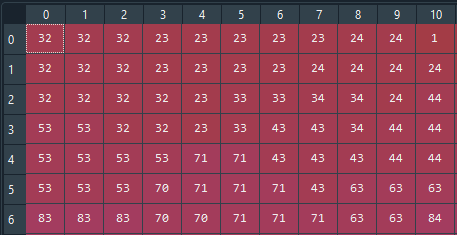   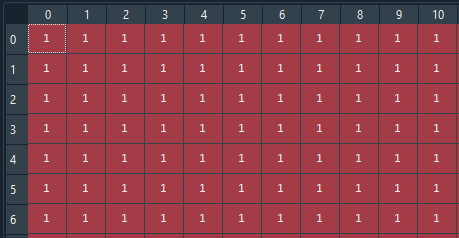        

(Text(0.5, 1.0, 'Watershed sobre sobel'), (-0.5, 159.5, 119.5, -0.5))

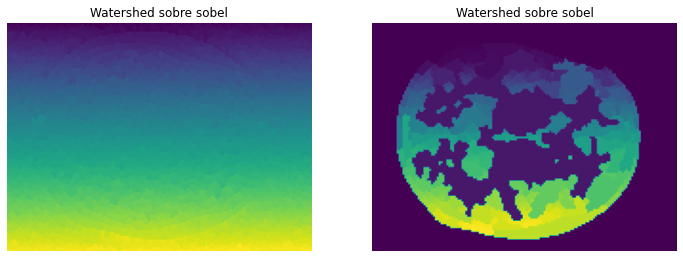

In [12]:
fig = plt.figure(figsize=(12,10))
plt.subplot(121)
plt.imshow(watershed1, cmap='viridis')
plt.title('Watershed sobre sobel'), plt.axis('off')
plt.subplot(122)
plt.imshow(watershed2, cmap='viridis')
plt.title('Watershed sobre sobel'), plt.axis('off')

### El problema de la sobresegmentación

Uno de los problemas que nos encontramos al realizar esta transformación es que ***en una imagen digital ruidosa nos encontramos un gran número de mínimos locales*** (debido a este ruido). Podemos poner el ejemplo del fondo, que a simple vista puede parecer completamente negro (lo que supondría tener píxeles con valor 0 en todo ese área) pero que en realidad tiene pequeñas variaciones de escala de gris debido al ruido.

Cada uno de estos mínimos locales va a ser interpretado como un mínimo correspondiente a una cuenca de Watershed independiente, lo que supone una gran sobresegmentación en pequeñas regiones como podemos ver en las imágenes de apartados superiores (que han sido creadas a partir de imágenes sin preprocesar). Además, tengamos en cuenta que por la naturaleza de nuestras imágenes (Resonancias Magnéticas) suele haber un orden de decenas de miles de mínimos locales.

>**Además debemos tener en cuenta que la transformación de Sobel, al ser un filtro derivativo, enfatizará aún más el ruido previo existente en la imagen original, provocando una sobresegmentación incluso mayor.**

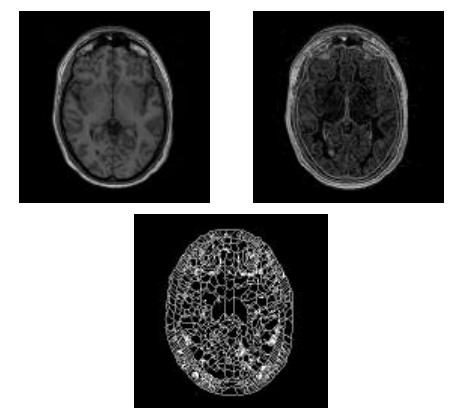

### Mejora de la calidad de la segmentación

Dicha sobresegmentación se puede reducir mediante un **filtrado suavizante** previo a la transformación de Sobel. Como hemos visto en la práctica anterior, existe una gran variedad de filtros de este tipo, pero debemos tener especial cuidado en la elección de este, ya que es necesaria la **preservación correcta de los bordes**.

Nosotras vamos a realizar una comparativa entre watershed obtenido a partir de la imagen sin filtrar original y watershed con imágenes filtradas con un filtro anisotrópico, filtro de mediana y filtro NLM. Nótese que estos filtros van a preservar los bordes mejor que otros filtros suavizantes.

estimated noise standard deviation = 0.022083760221752007


(Text(0.5, 1.0, 'Watershed sobre NLM'), (-0.5, 159.5, 119.5, -0.5))

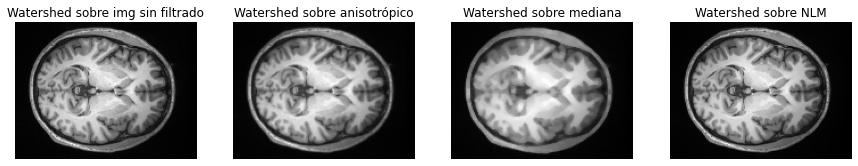

In [20]:
filtrada = modules.anisodiff(img_o)
img_medianfiltered = flt.median_filter(img_o,size = 4,mode='reflect')


# estimate the noise standard deviation from the noisy image
sigma_est = np.mean(estimate_sigma(img_o, multichannel=True))
print(f"estimated noise standard deviation = {sigma_est}")

patch_kw = dict(patch_size=3,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)
denoise_fast = denoise_nl_means(img_o, h=0.6 * sigma_est, fast_mode=True,**patch_kw)
fig = plt.figure(figsize=(15,10))
plt.subplot(141)
plt.imshow(img_o, cmap=plt.cm.gray)
plt.title('Watershed sobre img sin filtrado'), plt.axis('off')
plt.subplot(142)
plt.imshow(filtrada, cmap=plt.cm.gray)
plt.title('Watershed sobre anisotrópico'), plt.axis('off')
plt.subplot(143)
plt.imshow(img_medianfiltered, cmap=plt.cm.gray)
plt.title('Watershed sobre mediana'), plt.axis('off')
plt.subplot(144)
plt.imshow(denoise_fast, cmap=plt.cm.gray)
plt.title('Watershed sobre NLM'), plt.axis('off')

Obsevamos que el filtro NLM es el que mejor suaviza a la vez que preserva los bordes.

Vamos a introducir las mismas semillas a las tres transformaciones Watershed con el objetivo de poder realizar una comparativa justa.

In [14]:
%matplotlib auto
plt.figure()
plt.title('Semillas')
plt.imshow(img_o, cmap='gray') #Hacemos la representación la imagen para poder decidir donde posicionar las semillas
click_markers = plt.ginput(n=5) #Utilizamos la funcion .ginput() para posicionamiento de samillas, nótese que el número de estas lo introducimos como parámetro de la función
plt.close()
clicks = [(sub[1], sub[0]) for sub in click_markers] #cambiamos el orden de las tuplas obtenidas en .ginput() para poder usarlas como coordenadas.
markers = np.array(clicks,dtype = int) #transformamos la lista de tuplas a un array y pasamos de elementos float a int

print(markers)

Using matplotlib backend: Qt5Agg
[[ 11  53]
 [ 29  26]
 [ 61  17]
 [102  48]
 [ 99  94]]


Aplicamos la función **.WatershedNoGinput(img,markers)**  a la que estamos introduciendo la imagen a segmentar (original, y las tres preprocesadas) además de las semillas comunes.

In [21]:
%matplotlib auto
watershed1, watershed2 = modules.WatershedNoGinput(img_o,markers)
watershed1, watershed_aniso = modules.WatershedNoGinput(filtrada,markers)
watershed1, watershed_median = modules.WatershedNoGinput(img_medianfiltered,markers)
watershed1, watershed_nlm = modules.WatershedNoGinput(denoise_fast,markers)
img_sobel1=filters.sobel(filtrada) 


Using matplotlib backend: Qt5Agg


(Text(0.5, 1.0, 'Watershed sobre nlm'), (-0.5, 159.5, 119.5, -0.5))

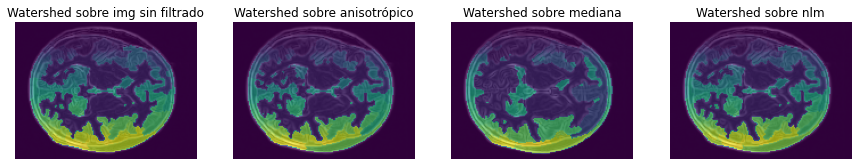

In [22]:
%matplotlib inline

fig = plt.figure(figsize=(15,10))
plt.subplot(141)
plt.imshow(img_sobel, cmap=plt.cm.gray)
plt.imshow(watershed2, cmap='viridis', alpha=0.7)
plt.title('Watershed sobre img sin filtrado'), plt.axis('off')
plt.subplot(142)
plt.imshow(img_sobel1, cmap=plt.cm.gray)
plt.imshow(watershed_aniso, cmap='viridis', alpha=0.7)
plt.title('Watershed sobre anisotrópico'), plt.axis('off')
plt.subplot(143)
plt.imshow(img_sobel1, cmap=plt.cm.gray)
plt.imshow(watershed_median, cmap='viridis', alpha=0.7)
plt.title('Watershed sobre mediana'), plt.axis('off')
plt.subplot(144)
plt.imshow(img_sobel1, cmap=plt.cm.gray)
plt.imshow(watershed_nlm, cmap='viridis', alpha=0.7)
plt.title('Watershed sobre nlm'), plt.axis('off')

> **Como cada nivel de color de las máscaras representa una región diferente segmentada por el algoritmo, esperamos que tras un preprocesado con un filtro suavizante obtengamos una homogeneización de las zonas que pertenecan a una misma región, y por ende, una reducción de las regiones segmentadas.**

(Text(0.5, 1.0, 'Watershed sobre nlm'), (-0.5, 159.5, 119.5, -0.5))

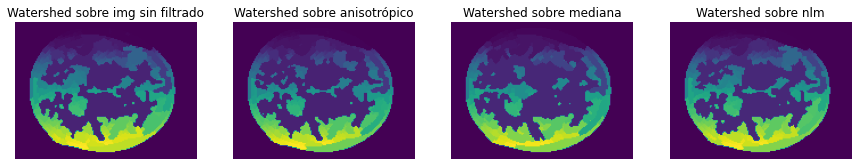

In [17]:
fig = plt.figure(figsize=(15,10))
plt.subplot(141)

plt.imshow(watershed2, cmap='viridis')
plt.title('Watershed sobre img sin filtrado'), plt.axis('off')
plt.subplot(142)

plt.imshow(watershed_aniso, cmap='viridis')
plt.title('Watershed sobre anisotrópico'), plt.axis('off')
plt.subplot(143)

plt.imshow(watershed_median, cmap='viridis')
plt.title('Watershed sobre mediana'), plt.axis('off')
plt.subplot(144)

plt.imshow(watershed_nlm, cmap='viridis')
plt.title('Watershed sobre nlm'), plt.axis('off')

Como vemos en los resultados de la celda anterior, podemos apreciar cambios en la segmentación entre la imagen sin un filtrado previo y los diferentes filtrados al aplicar Watershed, intrínsecos a las propiedades de los filtros suavizantes. Sin embargo, es importante no asumir automáticamente que cada una de las regiones que obtenemos tras el filtrado corresponde con una región anatómica, ya que dependiendo de la intensidad del filtro suavizante que apliquemos podríamos estar eliminando estructuras anatómicas importantes. Además, debemos tener especial cuidado en que, a pesar de que a simple vista parezca que en determinadas zonas obtenemos una región homogénea, si analizamos las matrices de las máscaras en Spyder en la mayoría de los casos que hemos probado esto no ocurre así.

## 5. Criterio en la selección de semillas

A continuación vamos a ver qué diferencia se produce al aumentar el número de semillas. Vamos a realizar una **segmentación de la sustancia blanca con 5, 10, 20 semillas**. 

Using matplotlib backend: Qt5Agg
Las coordenadas de las semillas son:  [[ 16  40]
 [ 19  92]
 [ 25 116]
 [ 36 127]
 [ 57 131]]
Las coordenadas de las semillas son:  [[100  91]
 [104  86]
 [ 99  41]
 [ 80  22]
 [ 62  19]
 [ 34  22]
 [ 20  37]
 [ 10  61]
 [ 17  93]
 [ 23 114]]
Las coordenadas de las semillas son:  [[ 24 114]
 [ 38 132]
 [ 61 133]
 [ 77 131]
 [ 91 121]
 [ 99  93]
 [103  86]
 [100  45]
 [ 84  26]
 [ 66  17]
 [ 41  18]
 [ 25  27]
 [ 15  43]
 [ 11  63]
 [ 15  88]
 [ 20  95]
 [ 28  83]
 [ 21 101]
 [ 28 120]
 [ 43 131]]


(Text(0.5, 1.0, 'Watershed con 20 semillas'), (-0.5, 159.5, 119.5, -0.5))

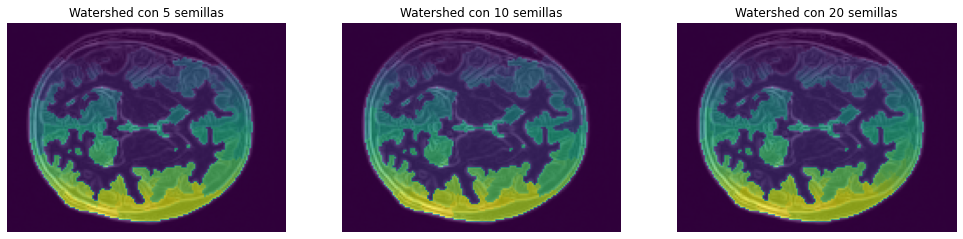

In [19]:
%matplotlib auto
watershed1, watershed2 =modules.WatershedExerciseP2(img_o,5)
watershed1, watershed3 =modules.WatershedExerciseP2(img_o,10)
watershed1, watershed4 =modules.WatershedExerciseP2(img_o,20)
img_sobel=filters.sobel(img_o)
%matplotlib inline

fig = plt.figure(figsize=(17,10))
plt.subplot(131)
plt.imshow(img_sobel, cmap=plt.cm.gray)
plt.imshow(watershed2, cmap='viridis', alpha=0.7)
plt.title('Watershed con 5 semillas'), plt.axis('off')
plt.subplot(132)
plt.imshow(img_sobel, cmap=plt.cm.gray)
plt.imshow(watershed3, cmap='viridis', alpha=0.7)
plt.title('Watershed con 10 semillas'), plt.axis('off')
plt.subplot(133)
plt.imshow(img_sobel, cmap=plt.cm.gray)
plt.imshow(watershed4, cmap='viridis', alpha=0.7)
plt.title('Watershed con 20 semillas'), plt.axis('off')

Como conclusión de esta comparativa obtenemos que **el algoritmo es más sensible a cambios en la posición de la semilla que al número de semillas**, ya que hemos visto que podríamos conseguir el mismo resultado Tanto con 20 como con 5 semillas variando su posición.

## 6. Conclusiones

Por todo el análisis realizado en los apartados anteriores concluimos que, el algoritmo Watershed puede ser de gran utilidad para realizar una segmentación de regiones si y solo si las imágenes originales favorecen a ello. En nuestro caso, debido a la gran complejidad de nuestras imágenes, consideramos que sería menester considerar otro tipo de algoritmos. Lo que sí que se podría evaluar es su uso como primera fase en un algoritmo de **Split and Merge** (fase de split o división en sub-regiones).

## 7. Referencias

J.E. Ortuño, N. Malpica, S. Reig, R. Martínez, M. Desco, A. Santos. (2001) Algoritmo Morfológico de Segmentación de Imágenes de Resonancia Magnética Normales Ponderadas en T1
http://www2.die.upm.es/im/papers/Caseib01_Ortuno.pdf

Luis M. Fuentes Tratamiento de Imagen y Sonido, UVa
https://alojamientos.uva.es/guia_docente/uploads/2013/413/40833/1/Documento3.pdf

Documentación de MathWorks: imimposemin
https://es.mathworks.com/help/images/ref/imimposemin.html

## 8. Autoría


Esta práctica ha sido realizada por **Mariana Nakagawa, María Pardo y Gema Pérez**. Consideramos que las aportaciones de cada una en todos los puntos del trabajo se deben tener en cuenta. Hemos colaborado todas en la elaboración de cada algoritmo y en la solución de problemas.